In [ ]:
#https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/gpt2_finetune_classification.ipynb

In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 29.3MB/s 
     |████████████████████████████████| 901kB 52.0MB/s 
     |████████████████████████████████| 1.2MB 48.9MB/s 
     |████████████████████████████████| 3.0MB 49.9MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip freeze > requirements.txt

In [ ]:
data_train = pd.read_csv('/content/train.csv')
data_train.head()

ID  ... Sub-task B
0  C45.451  ...       NGEN
1   C47.11  ...       NGEN
2   C33.79  ...       NGEN
3  C4.1961  ...       NGEN
4  C10.153  ...       NGEN

[5 rows x 4 columns]

In [ ]:
data_test = pd.read_csv('/content/test.csv')

In [ ]:
#data.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_train.drop(['ID','Sub-task B'], axis=1, inplace=True)


In [ ]:
NAG_train = data_train[(data_train['Sub-task A']=='NAG')]
OAG_train= data_train[(data_train['Sub-task A']=='CAG')]
CAG_train= data_train[(data_train['Sub-task A']=='OAG')]

In [ ]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0

In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_train["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_train["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_train["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1


In [ ]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [ ]:
data_train = pd.concat([NAG_train,
                  OAG_train,
                  CAG_train
                 ],axis=0)

data_train.reset_index(inplace=True)

In [ ]:
data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)
data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [ ]:
train, test = train_test_split(data_test, test_size=0.1, random_state=23)
train, val = train_test_split(data_train, test_size=0.3,random_state=23)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'you are a bad person , and you do not deserve good things'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: you are a bad person , and you do not deserve good things
   Tokens: ['you', 'are', 'a', 'bad', 'person', ',', 'and', 'you', 'do', 'not', 'deserve', 'good', 'things']
Token IDs: [1128, 1132, 170, 2213, 1825, 117, 1105, 1128, 1202, 1136, 10026, 1363, 1614]


In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
class_names = ['NAG', 'OAG', 'CAG']

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1128,  1132,   170,  2213,  1825,   117,  1105,  1128,  1202,
         1136, 10026,  1363,  1614,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class GPDataset(Dataset):
  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  data_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((3836, 3), (213, 3), (214, 3))

In [ ]:
MAX_LEN = 150

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPDataset(
    comments=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = Classifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5417, 0.1622, 0.2961],
        [0.4446, 0.2191, 0.3363],
        [0.6471, 0.1412, 0.2117],
        [0.5595, 0.2087, 0.2318],
        [0.6247, 0.1925, 0.1829],
        [0.3091, 0.1643, 0.5267],
        [0.5193, 0.1799, 0.3007],
        [0.4136, 0.3140, 0.2723],
        [0.4309, 0.3409, 0.2282],
        [0.6517, 0.1474, 0.2010],
        [0.5870, 0.1827, 0.2303],
        [0.4258, 0.3299, 0.2442],
        [0.5200, 0.1559, 0.3241],
        [0.2917, 0.3862, 0.3221],
        [0.4068, 0.3672, 0.2260],
        [0.4095, 0.2538, 0.3367]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 0.579240297836562 accuracy 0.7909280500521376
Val   loss 0.5550999875579562 accuracy 0.7417840375586855

Epoch 2/30
----------
Train loss 0.39320352929644287 accuracy 0.8404588112617309
Val   loss 0.620450130530766 accuracy 0.755868544600939

Epoch 3/30
----------
Train loss 0.23346154013221773 accuracy 0.9178832116788321
Val   loss 0.9695834602628436 accuracy 0.7136150234741784

Epoch 4/30
----------
Train loss 0.15013501687305203 accuracy 0.9562043795620438
Val   loss 1.3594937324523926 accuracy 0.755868544600939

Epoch 5/30
----------
Train loss 0.07776729752937778 accuracy 0.9796663190823776
Val   loss 1.4402275596346175 accuracy 0.7464788732394366

Epoch 6/30
----------
Train loss 0.03826620422817844 accuracy 0.989051094890511
Val   loss 1.6349206822259086 accuracy 0.7652582159624414

Epoch 7/30
----------
Train loss 0.014175673530492835 accuracy 0.9966110531803962
Val   loss 1.8133295178413391 accuracy 0.7417840375586855

Epoch 8/30
----------
Tra

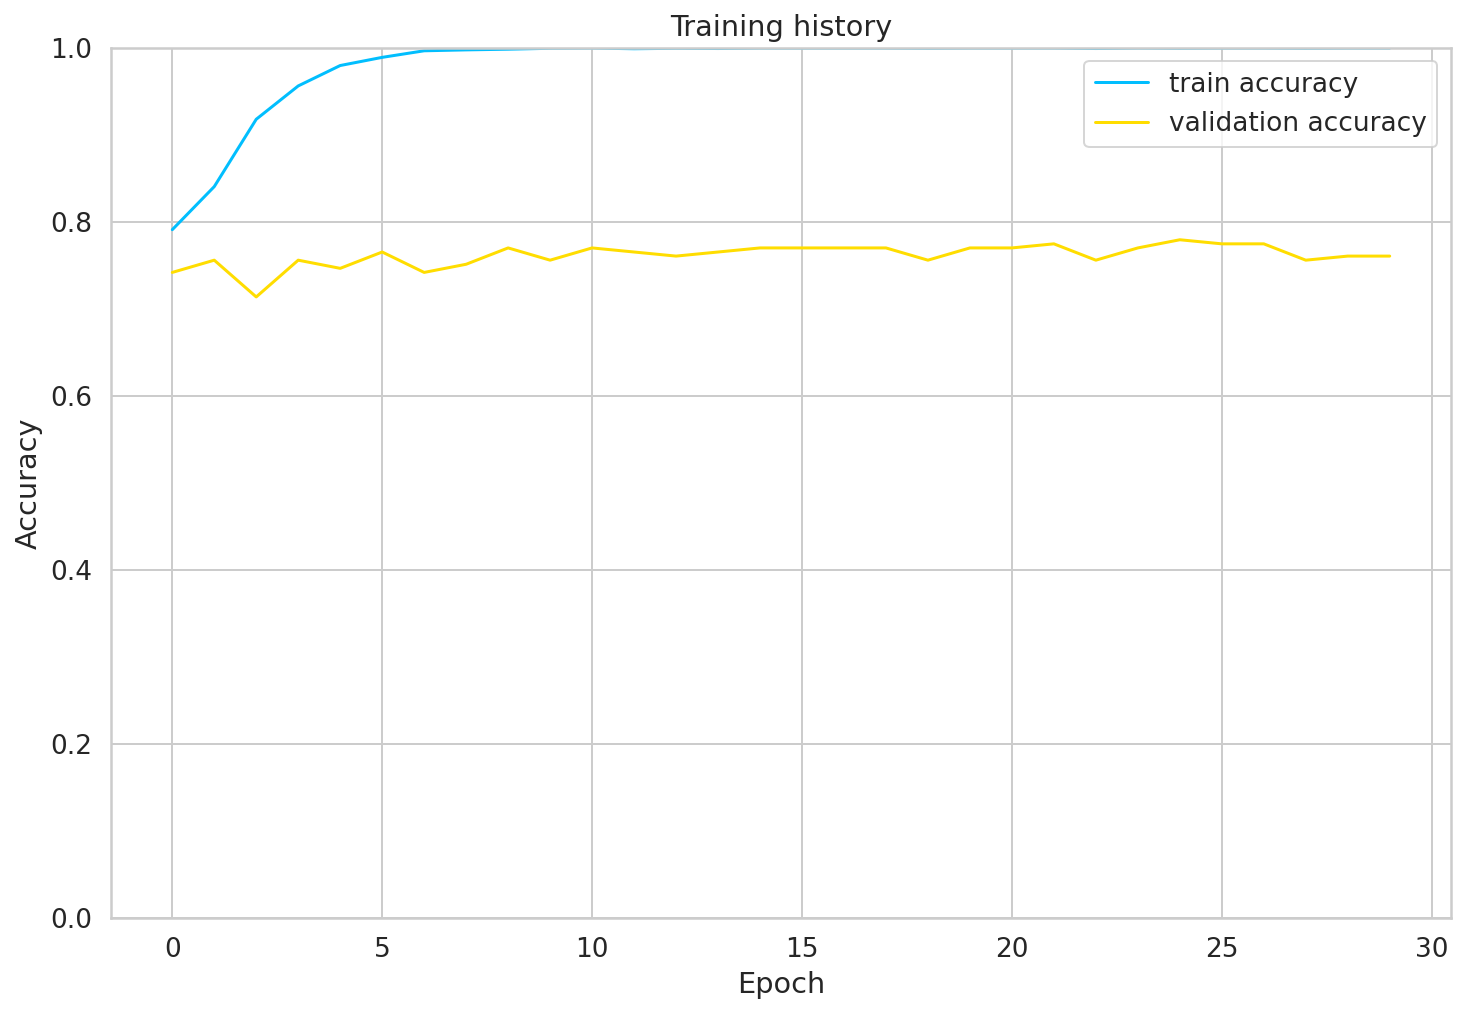

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

In [ ]:
y_comment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  aggr_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      aggr_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return aggr_texts, predictions, prediction_probs, real_values

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NAG       0.88      0.89      0.89       836
         OAG       0.33      0.37      0.35       117
         CAG       0.58      0.45      0.51       113

    accuracy                           0.79      1066
   macro avg       0.60      0.57      0.58      1066
weighted avg       0.79      0.79      0.79      1066



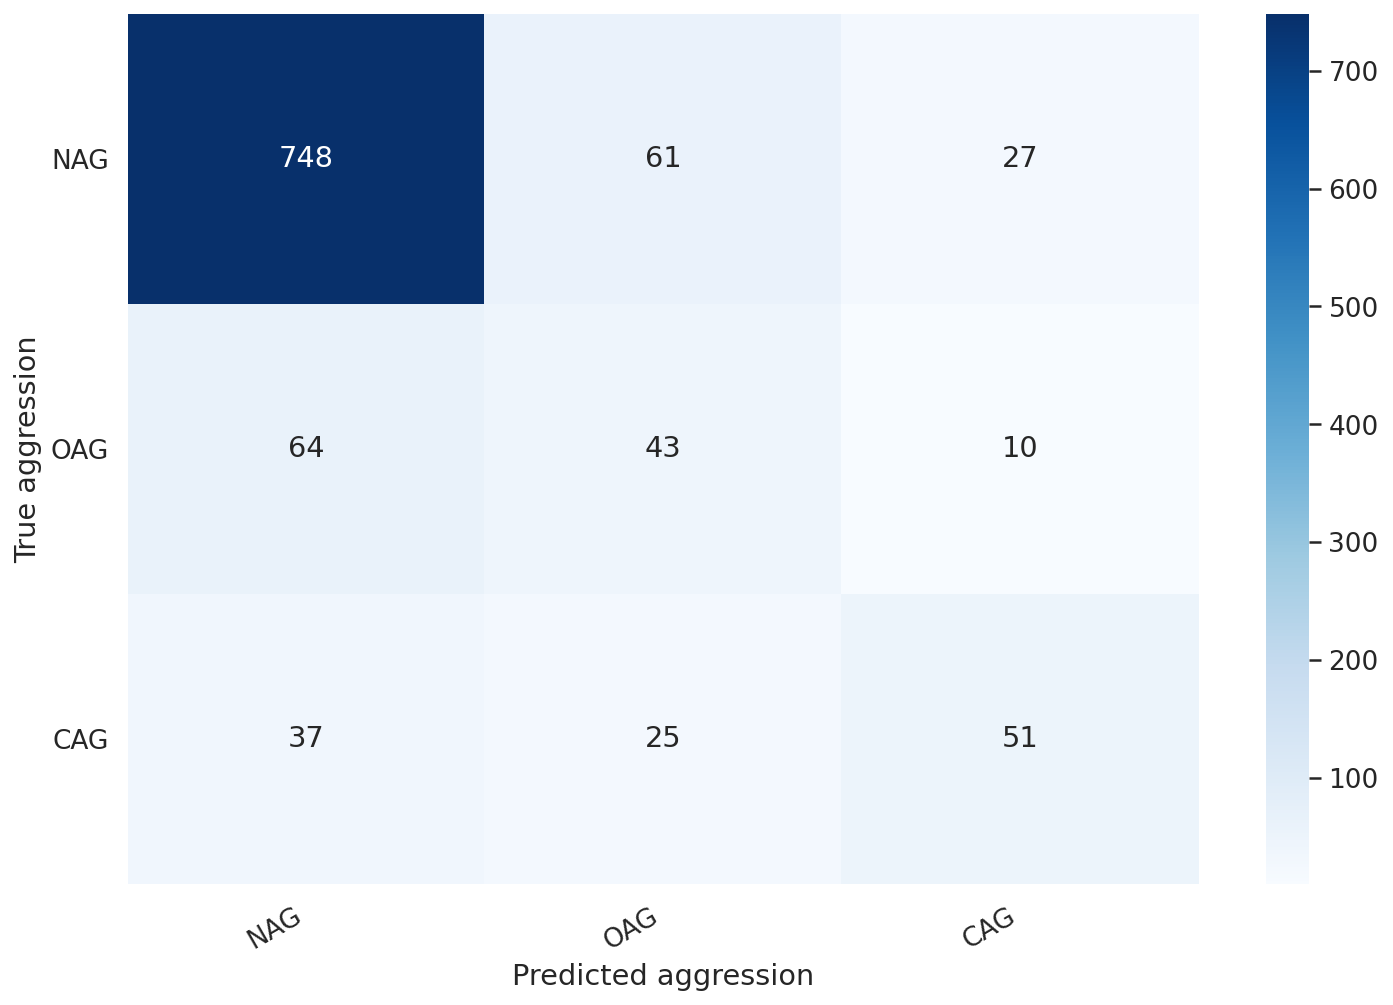

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True aggression')
  plt.xlabel('Predicted aggression');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2
comment_text = y_comment_texts[idx]
true_aggression = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(comment_text)))
print()
print(f'True aggression: {class_names[true_aggression]}')

sorry if i bother somebody.. iam a defence aspirant..   and i think
that homosexual shouldn't be allowed to join army as a general duty
personnel as we know that a different kind of atmosphere is there..
they have a very harsh routine there... abusing,hard workouts
unbearable pain unbearable punishment and manhandling for severe
mistakes(mainly in probation period) is normal... when such type of
thing will happen to them they could get a feeling of
discrimination(which is clearly not) however they can join clerical
medical supply signal corps as upper mention hardness is of less
magnitude there...

True aggression: NAG


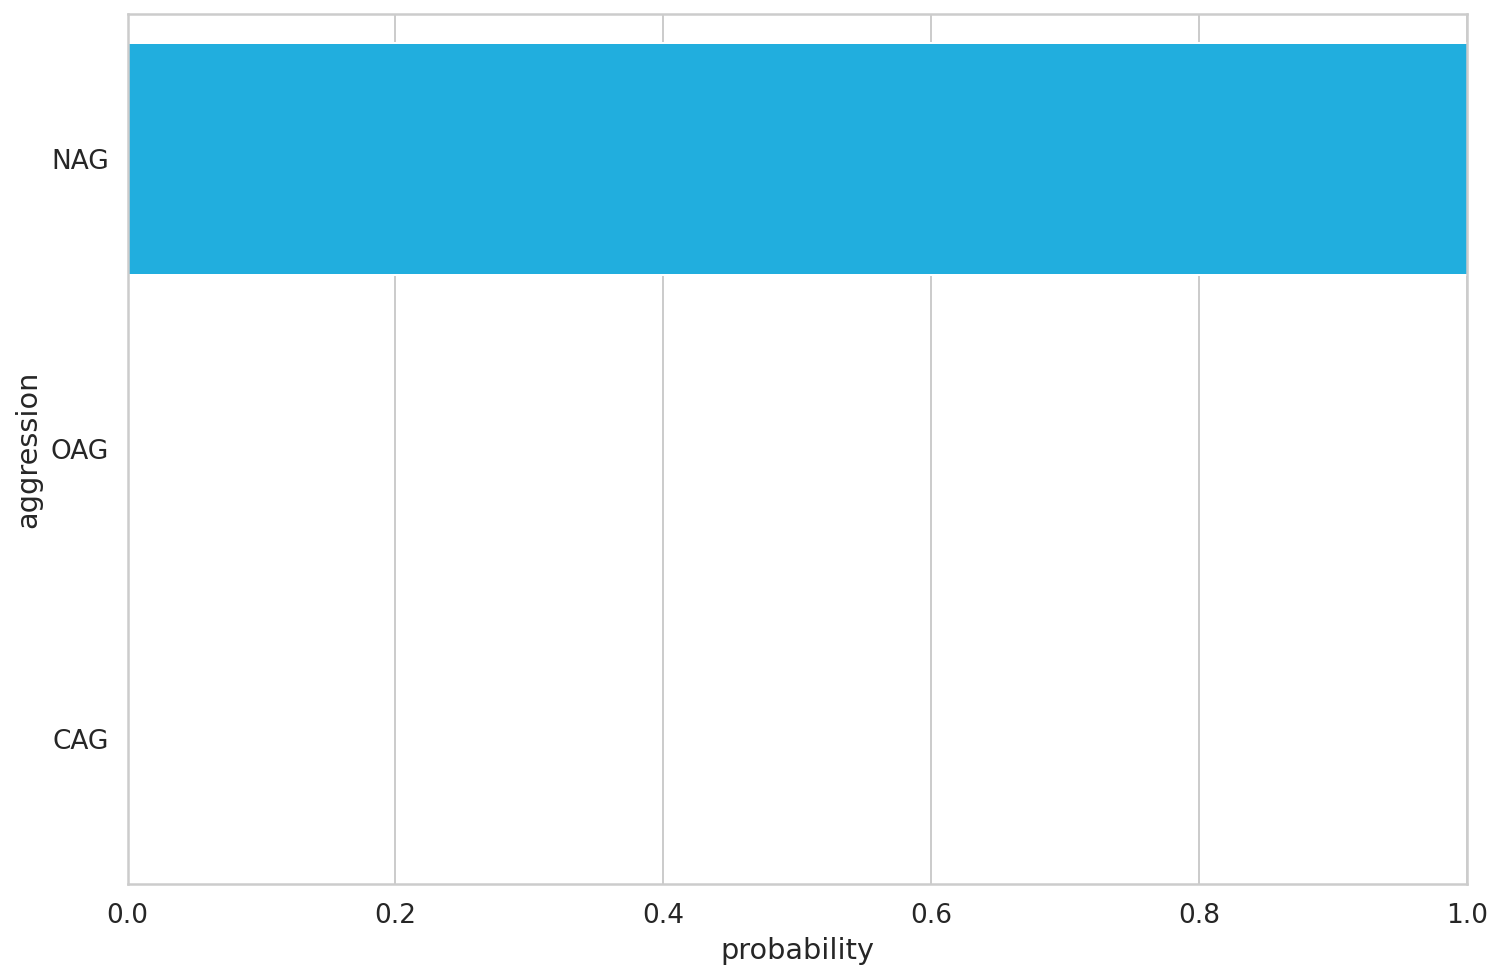

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('aggression')
plt.xlabel('probability')
plt.xlim([0, 1]);